In [1]:
import time
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
dataset_X = scipy.io.loadmat('./dataset/timeseries/Trace_data.mat')['data']
dataset_Y = scipy.io.loadmat('./dataset/timeseries/Trace_label.mat')['label'][0]

X, Y = [], []

class_1 = 1
class_2 = 4

for i in range(len(dataset_Y)):
  if dataset_Y[i] == class_1 or dataset_Y[i] == class_2:
    X.append(dataset_X[i])
    Y.append(dataset_Y[i])

X = np.array(X)
Y = np.array(Y)

In [3]:
X = np.array(X)
Y = np.where(Y == class_1, 1, -1)
print(np.where(Y == -1)[0])

[ 2  3  6  7  9 10 12 14 15 16 18 19 20 25 30 32 34 36 42]


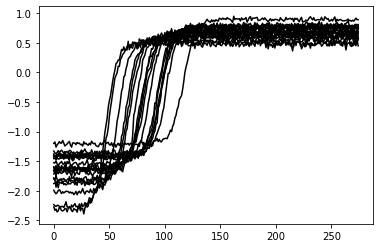

In [4]:
tmp = np.where(Y == -1)[0]
for i in range(len(tmp)):
  plt.plot(X[tmp[i]], 'k')
plt.show()

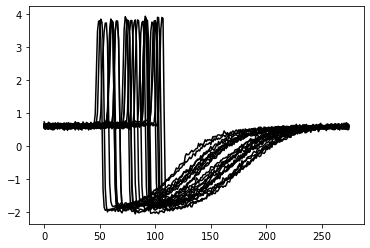

In [5]:
tmp = np.where(Y == 1)[0]
for i in range(len(tmp)):
  plt.plot(X[tmp[i]], 'k')

In [6]:
Y = np.array(Y).reshape(-1, 1)

In [8]:
train_cnt = 20

train_index = np.random.choice(len(X), size=train_cnt, replace=False)
test_index = [x for x in np.arange(0, len(X)) if x not in train_index]

train_X = X[train_index]
train_Y = Y[train_index]

test_X = X[test_index]
test_Y = Y[test_index]

In [9]:
print(np.shape(train_X))
print(np.shape(train_Y))

(20, 275)
(20, 1)


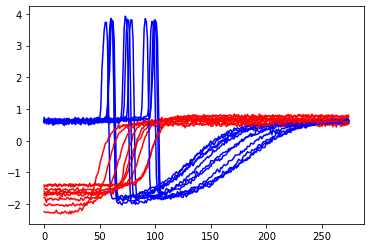

In [107]:
for i in range(len(train_X)):
  plt.plot(train_X[i].ravel(), 'b' if train_Y[i] == 1 else 'r')
plt.show()

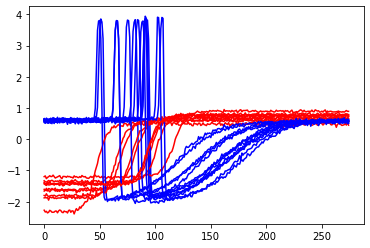

In [108]:
for i in range(len(test_X)):
  plt.plot(test_X[i].ravel(), 'b' if test_Y[i] == 1 else 'r')
plt.show()

In [109]:
BATCH_SIZE = int(np.shape(train_X)[0] / 2)
ITER = 10
LR = 0.01
GAMMA = 1.8

In [110]:
train_X_p = tf.placeholder(shape=[None, np.shape(train_X)[1]], dtype=tf.float32, name='train_X')
train_Y_p = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='train_Y')

b = tf.Variable(tf.random_uniform(shape=[1, BATCH_SIZE]))

pred_X_p = tf.placeholder(shape=[None, np.shape(train_X)[1]], dtype=tf.float32, name='prediction_X')
test_X_p = tf.placeholder(shape=[None, np.shape(test_X)[1]], dtype=tf.float32, name='test_X')
test_Y_p = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='test_Y')

In [111]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i)

  return dtw_array

In [112]:
gamma = tf.constant(GAMMA)
dtw_distances = tf.py_function(func=_dtw, inp=[train_X_p, train_X_p], Tout=[tf.float32 for i in range(BATCH_SIZE)])

kernel = tf.exp(-tf.multiply(gamma, dtw_distances))

In [113]:
first_term = tf.reduce_sum(b)

b_vec_cross = tf.matmul(tf.transpose(b), b)
train_Y_cross = tf.matmul(train_Y_p, tf.transpose(train_Y_p))
second_term = tf.reduce_sum(
    tf.multiply(kernel, tf.multiply(b_vec_cross, train_Y_cross))
)

loss = tf.negative(tf.subtract(first_term, second_term))

In [114]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[train_X_p, pred_X_p], Tout=[tf.float32 for i in range(BATCH_SIZE)])
pred_kernel = tf.exp(-tf.multiply(gamma, pred_dtw_distances))

prediction_output = tf.matmul(tf.multiply(tf.transpose(train_Y_p), b), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(train_Y_p)), tf.float32))

In [115]:
test_dtw_distances = tf.py_function(func=_dtw, inp=[train_X_p, test_X_p], Tout=[tf.float32 for i in range(BATCH_SIZE)])
test_kernel = tf.exp(-tf.multiply(gamma, test_dtw_distances))

test_prediction_output = tf.matmul(tf.multiply(tf.transpose(train_Y_p), b), test_kernel)
test_prediction = tf.sign(test_prediction_output - tf.reduce_mean(test_prediction_output))

test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(test_prediction), tf.squeeze(test_Y_p)), tf.float32))

In [116]:
optimizer = tf.train.GradientDescentOptimizer(LR)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

In [117]:
start = time.time()

loss_vec = []
batch_accuracy = []

for i in range(ITER):
  print('Step #' + str(i+1))
  local_start = time.time()

  rand_index = np.random.choice(len(train_X), size=BATCH_SIZE, replace=False)
  rand_X = train_X[rand_index]
  rand_Y = train_Y[rand_index]

  sess.run(train, feed_dict={train_X_p: rand_X, train_Y_p: rand_Y})
  temp_loss = sess.run(loss, feed_dict={train_X_p: rand_X, train_Y_p: rand_Y})
  loss_vec.append(temp_loss)

  acc_temp = sess.run(accuracy, feed_dict={train_X_p: rand_X, train_Y_p: rand_Y, pred_X_p: rand_X})
  batch_accuracy.append(acc_temp)

  print("accuracy :", acc_temp)
  print("loss:", str(temp_loss))
  print("time :", time.time() - local_start)

print("Total time :", time.time() - start)

Step #1
accuracy : 0.9
loss: -1.8350158
time : 18.49389624595642
Step #2
accuracy : 0.9
loss: -1.86134
time : 18.35291600227356
Step #3
accuracy : 1.0
loss: -1.8866367
time : 18.287943124771118
Step #4
accuracy : 1.0
loss: -1.9109325
time : 18.44658923149109
Step #5
accuracy : 1.0
loss: -1.9342628
time : 18.324410915374756
Step #6
accuracy : 0.9
loss: -1.9566536
time : 18.464592933654785
Step #7
accuracy : 1.0
loss: -1.9781806
time : 18.459527254104614
Step #8
accuracy : 1.0
loss: -1.9988434
time : 18.42142391204834
Step #9
accuracy : 1.0
loss: -2.0186875
time : 18.697192192077637
Step #10
accuracy : 1.0
loss: -2.0377424
time : 18.55478286743164
Total time : 184.50447511672974


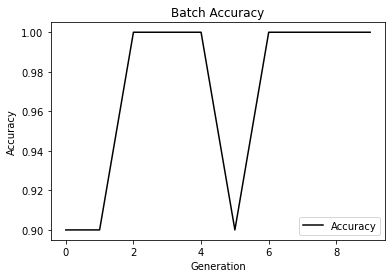

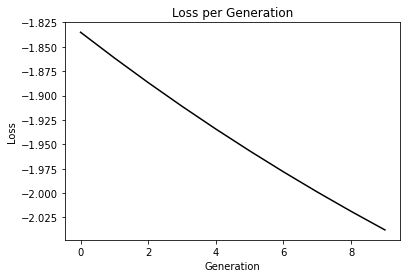

In [118]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [119]:
test_accuracy = sess.run(test_accuracy,
                         feed_dict={
                           train_X_p: train_X[rand_index],
                           train_Y_p: train_Y[rand_index],
                           test_X_p: test_X,
                           test_Y_p: test_Y
                           })
print(test_accuracy)

0.82608694


In [120]:
test_predictions = sess.run(test_prediction,
                    feed_dict={
                      train_X_p: train_X[rand_index],
                      train_Y_p: train_Y[rand_index],
                      test_X_p: test_X
                    })
test_predictions = np.squeeze(test_predictions)
test_Y = np.squeeze(test_Y)

count = 0
for i in range(len(test_predictions)):
  print(test_predictions[i], float(test_Y[i]))
  if test_predictions[i] == test_Y[i]:
    count += 1

print(count)
print(count / len(test_Y))

-1.0 1.0
1.0 1.0
-1.0 -1.0
1.0 1.0
-1.0 -1.0
-1.0 -1.0
-1.0 -1.0
-1.0 -1.0
-1.0 -1.0
1.0 1.0
-1.0 -1.0
-1.0 -1.0
-1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
-1.0 1.0
1.0 1.0
-1.0 1.0
-1.0 -1.0
1.0 1.0
1.0 1.0
-1.0 -1.0
19
0.8260869565217391


In [121]:
sess.close()